In [1]:
# ÏãúÏûëÌïòÍ∏∞: ÌçºÏÇ¨Îìú ÏûÑÌè¨Ìä∏
from qdl.facade import QDL
import pandas as pd
import numpy as np
from qdl import validator

In [2]:
q = QDL()
# Ìå©ÌÑ∞ Î¶¨Ïä§Ìä∏ Ï†ïÏùò
factors = ["market_equity", "be_me", "ope_be", "at_gr1", "ret_12_1", "ret_1_0"]

# Î£®ÌîÑ ÎèåÎ©¥ÏÑú wide DataFrame ÏÉùÏÑ±
for factor in factors:
    globals()[f"wide_{factor}"] = q.load_char(
        country="usa",
        vintage="2020-",
        char=factor,
        date_col="eom"
    )

# ÌôïÏù∏ (Í∞Å DataFrame shape Ï∂úÎ†•)
for factor in factors:
    df = globals()[f"wide_{factor}"]
    print(f"wide_{factor}: {df.shape}")

wide_market_equity: (62, 12123)
wide_be_me: (62, 12123)
wide_ope_be: (62, 12123)
wide_at_gr1: (62, 12123)
wide_ret_12_1: (62, 12123)
wide_ret_1_0: (62, 12123)


In [3]:
# ÌäπÏÑ±(Chars) Îç∞Ïù¥ÌÑ∞ÏÖã (ÏôÄÏù¥Îìú): size_grp
wide_size_grp = q.load_char(
    country="usa",
    vintage="2020-",
    char="size_grp",
    date_col = "eom")

# ÌäπÏÑ±(Chars) Îç∞Ïù¥ÌÑ∞ÏÖã (ÏôÄÏù¥Îìú): Ï¥àÍ≥ºÏàòÏùµÎ•† 
wide_ret_exc = q.load_char(
    country="usa",
    vintage="2020-",
    char="ret_exc",
    date_col="eom")


In [4]:
# Í≤∞Í≥º Ï†ÄÏû•Ïö© ÎîïÏÖîÎÑàÎ¶¨
top_portfolios = {}
middle_portfolios = {}
bottom_portfolios = {}

for factor in factors:
    print(f"=== {factor} Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÎ•ò ÏãúÏûë ===")
    
    # 1. non-micro ÎßàÏä§ÌÅ¨
    non_micro_mask = ~wide_size_grp.isin(["micro", "nano"])
    
    # 2. non-micro Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú
    wide_df = globals()[f"wide_{factor}"]
    wide_non_micro = wide_df.where(non_micro_mask)
    
    # 3. cross-sectional rank (non-micro Í∏∞Ï§Ä)
    xs_rank = wide_non_micro.rank(axis=1, method="min", pct=True)
    
    high_mask = xs_rank >= 0.666
    low_mask  = xs_rank <= 0.333
    
    non_micro_top    = xs_rank.where(high_mask)
    non_micro_bottom = xs_rank.where(low_mask)
    non_micro_middle = xs_rank.where(~high_mask & ~low_mask)
    
    # 4. Î∂ÑÏúÑÏàò cutoff (non-microÎßå Í∏∞Ï§Ä)
    q_low  = wide_non_micro.quantile(0.333, axis=1)
    q_high = wide_non_micro.quantile(0.666, axis=1)
    
    # 5. micro Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú
    micro_mask = wide_size_grp.isin(["micro", "nano"])
    wide_micro = wide_df.where(micro_mask)
    
    # 6. micro Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÎ•ò (non-micro cutoff Í∏∞Ï§Ä ÏÇ¨Ïö©)
    micro_top    = wide_micro.where(wide_micro.ge(q_high, axis=0))
    micro_bottom = wide_micro.where(wide_micro.le(q_low, axis=0))
    micro_middle = wide_micro.where(
        (wide_micro.gt(q_low, axis=0)) & (wide_micro.lt(q_high, axis=0))
    )
    
    # 7. non-micro + micro Ìï©ÏπòÍ∏∞ (ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§)
    top_portfolios[factor]    = non_micro_top.combine_first(micro_top)
    middle_portfolios[factor] = non_micro_middle.combine_first(micro_middle)
    bottom_portfolios[factor] = non_micro_bottom.combine_first(micro_bottom)
    
    print(f"=== {factor} ÏôÑÎ£å ===\n")


=== market_equity Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÎ•ò ÏãúÏûë ===
=== market_equity ÏôÑÎ£å ===

=== be_me Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÎ•ò ÏãúÏûë ===
=== be_me ÏôÑÎ£å ===

=== ope_be Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÎ•ò ÏãúÏûë ===
=== ope_be ÏôÑÎ£å ===

=== at_gr1 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÎ•ò ÏãúÏûë ===
=== at_gr1 ÏôÑÎ£å ===

=== ret_12_1 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÎ•ò ÏãúÏûë ===
=== ret_12_1 ÏôÑÎ£å ===

=== ret_1_0 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÎ•ò ÏãúÏûë ===
=== ret_1_0 ÏôÑÎ£å ===



In [5]:
# ÎÇ†ÏßúÎ≥ÑÎ°ú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§Ïóê Ìè¨Ìï®Îêú Ï£ºÏãù Ïàò Ïπ¥Ïö¥Ìä∏

# ÏàòÏ†ïÎêú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï†ÄÏû• dict
filtered_top_portfolios = {}
filtered_middle_portfolios = {}
filtered_bottom_portfolios = {}

for factor in factors:
    print(f"=== {factor.upper()} Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌïÑÌÑ∞ÎßÅ ===")
    
    # ÏõêÎûò Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂àÎü¨Ïò§Í∏∞
    top_df    = top_portfolios[factor]
    middle_df = middle_portfolios[factor]
    bottom_df = bottom_portfolios[factor]
    
    # ÎÇ†ÏßúÎ≥Ñ Ï¢ÖÎ™© Ïàò
    top_count    = top_df.notna().sum(axis=1)
    middle_count = middle_df.notna().sum(axis=1)
    bottom_count = bottom_df.notna().sum(axis=1)
    
    # 5Í∞ú ÎØ∏ÎßåÏù∏ ÎÇ†Ïßú Ï∞æÍ∏∞
    invalid_dates = (top_count < 5) | (middle_count < 5) | (bottom_count < 5)
    
    if invalid_dates.any():
        print(f"{factor}: ‚ö†Ô∏è {invalid_dates.sum()} Í∞ú Ïõî Ï†úÏô∏")
        
        # Ìï¥Îãπ Ïõî Ï†ÑÏ≤¥Î•º NaN Ï≤òÎ¶¨ (top/middle/bottom Î™®Îëê Ï†úÏô∏)
        top_df.loc[invalid_dates, :]    = float("nan")
        middle_df.loc[invalid_dates, :] = float("nan")
        bottom_df.loc[invalid_dates, :] = float("nan")
    else:
        print(f"{factor}: ‚úÖ Î™®Îì† ÏõîÏóêÏÑú 5Í∞ú Ïù¥ÏÉÅ Ïú†ÏßÄ")
    
    # ÌïÑÌÑ∞ÎßÅÎêú Í≤∞Í≥º Ï†ÄÏû•
    filtered_top_portfolios[factor]    = top_df
    filtered_middle_portfolios[factor] = middle_df
    filtered_bottom_portfolios[factor] = bottom_df

    # Ï†úÏô∏Îêú ÏõîÏùò ÎÇ†ÏßúÏôÄ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© Ïàò Ï∂úÎ†•
for factor in factors:
    print(f"\n=== {factor.upper()} Ï†úÏô∏Îêú Ïõî ÏÉÅÏÑ∏ ===")
    
    # ÏõêÎûò Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂àÎü¨Ïò§Í∏∞
    top_df    = top_portfolios[factor]
    middle_df = middle_portfolios[factor]
    bottom_df = bottom_portfolios[factor]
    
    # ÎÇ†ÏßúÎ≥Ñ Ï¢ÖÎ™© Ïàò
    top_count    = top_df.notna().sum(axis=1)
    middle_count = middle_df.notna().sum(axis=1)
    bottom_count = bottom_df.notna().sum(axis=1)
    
    # 5Í∞ú ÎØ∏ÎßåÏù∏ ÎÇ†Ïßú
    invalid_dates = (top_count < 5) | (middle_count < 5) | (bottom_count < 5)
    
    if invalid_dates.any():
        invalid_info = pd.DataFrame({
            "Top_count": top_count[invalid_dates],
            "Middle_count": middle_count[invalid_dates],
            "Bottom_count": bottom_count[invalid_dates],
        })
        print(invalid_info)
    else:
        print("‚úÖ Ï†úÏô∏Îêú Ïõî ÏóÜÏùå")


=== MARKET_EQUITY Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌïÑÌÑ∞ÎßÅ ===
market_equity: ‚úÖ Î™®Îì† ÏõîÏóêÏÑú 5Í∞ú Ïù¥ÏÉÅ Ïú†ÏßÄ
=== BE_ME Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌïÑÌÑ∞ÎßÅ ===
be_me: ‚ö†Ô∏è 1 Í∞ú Ïõî Ï†úÏô∏
=== OPE_BE Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌïÑÌÑ∞ÎßÅ ===
ope_be: ‚úÖ Î™®Îì† ÏõîÏóêÏÑú 5Í∞ú Ïù¥ÏÉÅ Ïú†ÏßÄ
=== AT_GR1 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌïÑÌÑ∞ÎßÅ ===
at_gr1: ‚úÖ Î™®Îì† ÏõîÏóêÏÑú 5Í∞ú Ïù¥ÏÉÅ Ïú†ÏßÄ
=== RET_12_1 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌïÑÌÑ∞ÎßÅ ===
ret_12_1: ‚úÖ Î™®Îì† ÏõîÏóêÏÑú 5Í∞ú Ïù¥ÏÉÅ Ïú†ÏßÄ
=== RET_1_0 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌïÑÌÑ∞ÎßÅ ===
ret_1_0: ‚úÖ Î™®Îì† ÏõîÏóêÏÑú 5Í∞ú Ïù¥ÏÉÅ Ïú†ÏßÄ

=== MARKET_EQUITY Ï†úÏô∏Îêú Ïõî ÏÉÅÏÑ∏ ===
‚úÖ Ï†úÏô∏Îêú Ïõî ÏóÜÏùå

=== BE_ME Ï†úÏô∏Îêú Ïõî ÏÉÅÏÑ∏ ===
            Top_count  Middle_count  Bottom_count
eom                                              
2025-02-28          0             0             0

=== OPE_BE Ï†úÏô∏Îêú Ïõî ÏÉÅÏÑ∏ ===
‚úÖ Ï†úÏô∏Îêú Ïõî ÏóÜÏùå

=== AT_GR1 Ï†úÏô∏Îêú Ïõî ÏÉÅÏÑ∏ ===
‚úÖ Ï†úÏô∏Îêú Ïõî ÏóÜÏùå

=== RET_12_1 Ï†úÏô∏Îêú Ïõî ÏÉÅÏÑ∏ ===
‚úÖ Ï†úÏô∏Îêú Ïõî ÏóÜÏùå

=== RET_1_0 Ï†úÏô∏Îê

In [6]:
# ÎßàÏä§ÌÅ¨ Ï†ÄÏû•Ïö© dict
top_masks = {}
middle_masks = {}
bottom_masks = {}

for factor in factors:
    print(f"=== {factor.upper()} ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± ===")
    
    # ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂àÎü¨Ïò§Í∏∞ (ÌïÑÌÑ∞ÎßÅÎêú Î≤ÑÏ†Ñ Ïì∞ÏÖîÎèÑ Îê®)
    top_df    = filtered_top_portfolios[factor]
    middle_df = filtered_middle_portfolios[factor]
    bottom_df = filtered_bottom_portfolios[factor]
    
    # notna() ‚Üí Î∂àÎ¶¨Ïñ∏ ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
    top_masks[factor]    = top_df.notna()
    middle_masks[factor] = middle_df.notna()
    bottom_masks[factor] = bottom_df.notna()

=== MARKET_EQUITY ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± ===
=== BE_ME ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± ===
=== OPE_BE ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± ===
=== AT_GR1 ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± ===
=== RET_12_1 ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± ===
=== RET_1_0 ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± ===


EW

In [7]:
# Top=Short Ïù∏ Ìå©ÌÑ∞Îì§
top_as_short = ["market_equity", "at_gr1", "ret_1_0"]

# Í≤∞Í≥º Ï†ÄÏû• dict
short_ports = {}
long_ports = {}

for factor in factors:
    print(f"=== {factor.upper()} Î°±/Ïàè Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===")
    
    top_mask    = top_masks[factor].shift(1)     # forward-looking Î∞©ÏßÄ
    bottom_mask = bottom_masks[factor].shift(1)
    
    if factor in top_as_short:
        # Top = Short, Bottom = Long
        short_ports[factor] = -1 * wide_ret_exc.where(top_mask)
        long_ports[factor]  =      wide_ret_exc.where(bottom_mask)
    else:
        # Top = Long, Bottom = Short
        short_ports[factor] = -1 * wide_ret_exc.where(bottom_mask)
        long_ports[factor]  =      wide_ret_exc.where(top_mask)

=== MARKET_EQUITY Î°±/Ïàè Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== BE_ME Î°±/Ïàè Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== OPE_BE Î°±/Ïàè Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== AT_GR1 Î°±/Ïàè Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== RET_12_1 Î°±/Ïàè Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== RET_1_0 Î°±/Ïàè Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===


=== MARKET_EQUITY EW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== BE_ME EW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== OPE_BE EW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== AT_GR1 EW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_12_1 EW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_1_0 EW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===


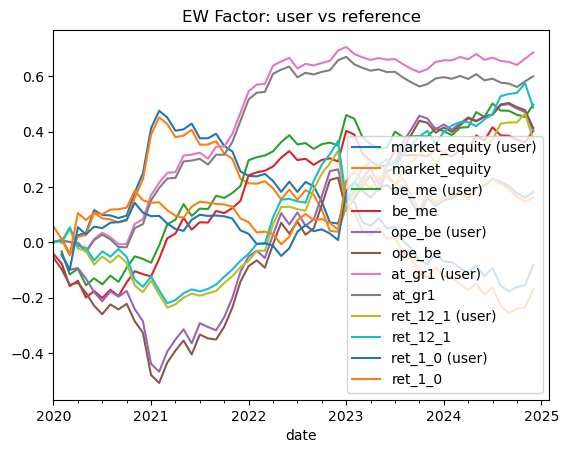

In [8]:
# Í≤∞Í≥º Ï†ÄÏû• dict
factor_returns_ew = {}
factor_answers_ew = {}

for factor in factors:
    print(f"=== {factor.upper()} EW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===")
    
    # 1. ÏßÅÏ†ë Í≥ÑÏÇ∞ (short/longÏùÄ ÏïûÏóêÏÑú ÎßåÎì† dict ÏÇ¨Ïö©)
    short_port = short_ports[factor]
    long_port  = long_ports[factor]
    
    short_ret = short_port.mean(axis=1)
    long_ret  = long_port.mean(axis=1)
    
    factor_ret_ew = short_ret + long_ret   # factor = short + long
    factor_returns_ew[factor] = factor_ret_ew
    
    # 2. reference Î∂àÎü¨Ïò§Í∏∞
    factor_answer = q.load_factors(
        country="usa",
        dataset="factor",
        weighting="ew",
        factors=[factor],
    )
    factor_answers_ew[factor] = factor_answer
    
    # 3. Í∑∏ÎûòÌîÑ ÎπÑÍµê
    ax = factor_ret_ew.cumsum().plot(label=f"{factor} (user)")
    factor_answer.loc["2020-01-31":, :].cumsum().plot(ax=ax, label=f"{factor} (ref)")
    ax.set_title("EW Factor: user vs reference")
    ax.legend()


=== MARKET_EQUITY EW Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 59Í∞ú (2020-02-29 00:00:00 ~ 2024-12-31 00:00:00)
[DEBUG] ref_factor : 1188Í∞ú (1926-01-31 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 59 ÏãúÏûëÏùº: 2020-02-29 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.002 mae: 0.002 corr: 0.999

=== BE_ME EW Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 59Í∞ú (2020-02-29 00:00:00 ~ 2024-12-31 00:00:00)
[DEBUG] ref_factor : 890Í∞ú (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 59 ÏãúÏûëÏùº: 2020-02-29 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.002 mae: 0.001 corr: 0.999

=== OPE_BE EW Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 59Í∞ú (2020-02-29 00:00:00 ~ 2024-12-31 00:00:00)
[DEBUG] ref_factor : 890Í∞ú (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 59 ÏãúÏûëÏùº: 2020-02-29 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.002 mae: 0.001 corr: 1.000

=== AT_GR1 EW Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 59Í∞ú (2020-02-29 00:00:00 ~ 2024-12

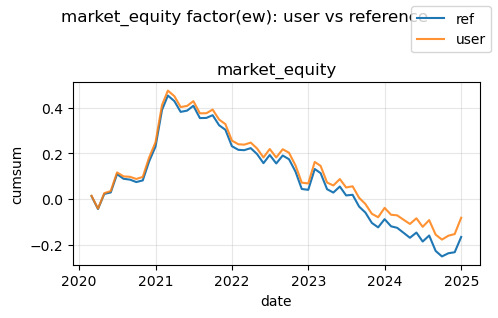

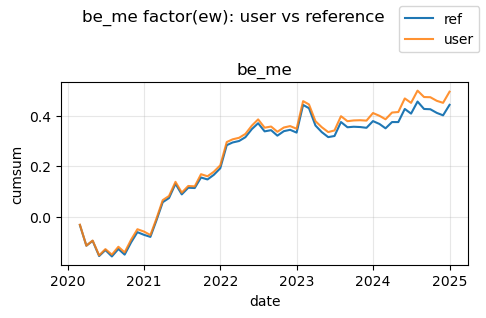

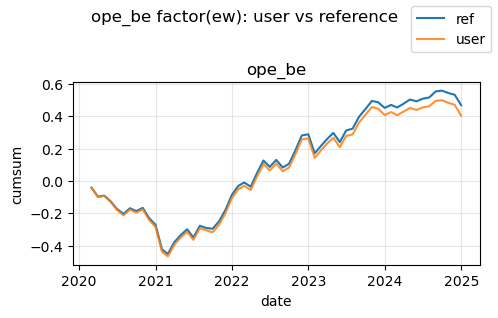

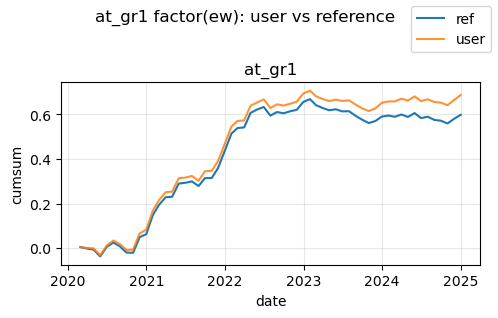

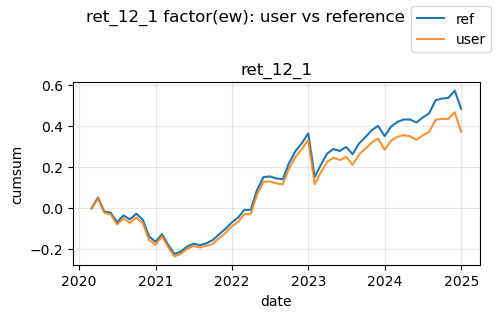

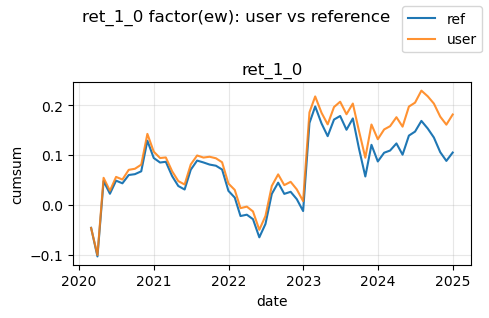

In [9]:
# Í≤∞Í≥º Ï†ÄÏû• dict
validation_reports = {}

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

for factor in factors:
    print(f"\n=== {factor.upper()} EW Factor Í≤ÄÏ¶ù ===")
    
    # 1. user factor (Series ‚Üí DataFrame)
    user_factor = pd.DataFrame(factor_returns_ew[factor])
    user_factor.columns = [factor]
    
    # 2. reference factor
    ref_factor = factor_answers_ew[factor]
    
    # üîé Í∏∏Ïù¥ Î∞è ÎÇ†Ïßú Î≤îÏúÑ Ï≤¥ÌÅ¨
    print(f"[DEBUG] user_factor: {user_factor.dropna().shape[0]}Í∞ú "
          f"({user_factor.dropna().index.min()} ~ {user_factor.dropna().index.max()})")
    print(f"[DEBUG] ref_factor : {ref_factor.dropna().shape[0]}Í∞ú "
          f"({ref_factor.dropna().index.min()} ~ {ref_factor.dropna().index.max()})")
    
    # 3. validator Ïã§Ìñâ
    report = validator.validate_factor(
        user=user_factor,
        reference=ref_factor,
        return_plot=True,
        plot_title=f"{factor} factor(ew): user vs reference",
    )
    
    # 4. Í≤∞Í≥º Ï∂úÎ†•
    print("Í¥ÄÏ∏°ÏπòÏàò:", report.n_obs, 
          "ÏãúÏûëÏùº:", report.date_start, 
          "Ï¢ÖÎ£åÏùº:", report.date_end)
    print(
        "mse:", _fmt(report.mse),
        "rmse:", _fmt(report.rmse),
        "mae:", _fmt(report.mae),
        "corr:", _fmt(report.corr),
    )
    
    # 5. dictÏóê Ï†ÄÏû•
    validation_reports[factor] = report


VW

=== MARKET_EQUITY VW Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== BE_ME VW Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== OPE_BE VW Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== AT_GR1 VW Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== RET_12_1 VW Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== RET_1_0 VW Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===
=== MARKET_EQUITY VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== BE_ME VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== OPE_BE VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== AT_GR1 VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== RET_12_1 VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== RET_1_0 VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== MARKET_EQUITY VW ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== BE_ME VW ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== OPE_BE VW ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== AT_GR1 VW ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_12_1 VW ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_1_0 VW ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== MARKET_EQUITY VW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== BE_ME VW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== OPE_BE VW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== AT_GR1 VW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_12_1 VW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_1_0 VW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===


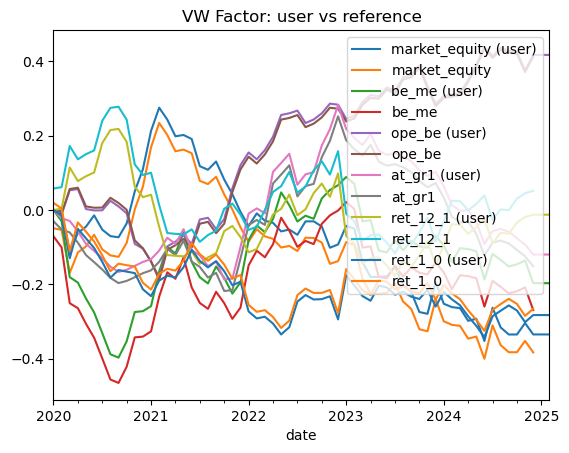

In [17]:
# Top=Short Ïù∏ Ìå©ÌÑ∞Îì§
top_as_short = ["market_equity", "at_gr1", "ret_1_0"]

# === Í≤∞Í≥º Ï†ÄÏû• dict ===
short_ports_vw = {}
long_ports_vw = {}

# === VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ Ìï®Ïàò ===
def get_portfolio_vw_weights(me_df, mask_shifted):
    """
    me_df         : wide_{factor} (factorÎ≥Ñ ÏôÄÏù¥Îìú ME Îç∞Ïù¥ÌÑ∞)
    mask_shifted  : t-1 ÏãúÏ†ê Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎßàÏä§ÌÅ¨
    """
    port_me = me_df.where(mask_shifted)                 # Ìè¨Ìä∏ MEÎßå ÎÇ®ÍπÄ
    return port_me.div(port_me.sum(axis=1), axis=0)     # Œ£Ìè¨Ìä∏ MEÎ°ú ÎÇòÎà†ÏÑú Ï†ïÍ∑úÌôî

for factor in factors:
    print(f"=== {factor.upper()} VW Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í≥ÑÏÇ∞ ===")
    
    # 1. wide_{factor} ME Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
    me_df = globals()[f"wide_{factor}"]
    
    # 2. ÎßàÏä§ÌÅ¨ Î∂àÎü¨Ïò§Í∏∞ (t-1 Í∏∞Ï§ÄÏúºÎ°ú shift Ï†ÅÏö©)
    top_mask_shifted    = top_masks[factor].shift(1)
    middle_mask_shifted = middle_masks[factor].shift(1)
    bottom_mask_shifted = bottom_masks[factor].shift(1)
    
    # 3. VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    top_weights    = get_portfolio_vw_weights(me_df.shift(1), top_mask_shifted)
    middle_weights = get_portfolio_vw_weights(me_df.shift(1), middle_mask_shifted)
    bottom_weights = get_portfolio_vw_weights(me_df.shift(1), bottom_mask_shifted)
    
    # 4. ret_exc √ó weight ‚Üí Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•†
    top_ret    = (wide_ret_exc * top_weights).sum(axis=1)
    middle_ret = (wide_ret_exc * middle_weights).sum(axis=1)
    bottom_ret = (wide_ret_exc * bottom_weights).sum(axis=1)
    
    # 5. Ìå©ÌÑ∞ Î∞©Ìñ• Ï†ÅÏö© (Top=Short or Bottom=Short)
    if factor in top_as_short:
        short_ports_vw[factor] = top_ret
        long_ports_vw[factor]  = bottom_ret
    else:
        short_ports_vw[factor] = bottom_ret
        long_ports_vw[factor]  = top_ret

# === VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ Ìï®Ïàò ===
def get_portfolio_vw_weights(me_df, mask_shifted):
    """
    me_df         : wide_{factor} (factorÎ≥Ñ ÏôÄÏù¥Îìú ME Îç∞Ïù¥ÌÑ∞)
    mask_shifted  : t-1 ÏãúÏ†ê Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎßàÏä§ÌÅ¨
    """
    port_me = me_df.where(mask_shifted)                 # Ìè¨Ìä∏ MEÎßå ÎÇ®ÍπÄ
    return port_me.div(port_me.sum(axis=1), axis=0)     # Œ£Ìè¨Ìä∏ MEÎ°ú ÎÇòÎà†ÏÑú Ï†ïÍ∑úÌôî


# === Í≤∞Í≥º Ï†ÄÏû• dict ===
top_weights_vw = {}
middle_weights_vw = {}
bottom_weights_vw = {}

for factor in factors:
    print(f"=== {factor.upper()} VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===")
    
    # (1) wide_{factor} ME Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
    me_df = wide_market_equity
    
    # (2) Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎßàÏä§ÌÅ¨ (t-1 Í∏∞Ï§Ä shift)
    top_mask_shifted    = top_masks[factor].shift(1)
    middle_mask_shifted = middle_masks[factor].shift(1)
    bottom_mask_shifted = bottom_masks[factor].shift(1)
    
    # (3) VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    top_weights_vw[factor]    = get_portfolio_vw_weights(me_df.shift(1), top_mask_shifted)
    middle_weights_vw[factor] = get_portfolio_vw_weights(me_df.shift(1), middle_mask_shifted)
    bottom_weights_vw[factor] = get_portfolio_vw_weights(me_df.shift(1), bottom_mask_shifted)

# === Ìè¨Ìä∏Ìè¥Î¶¨Ïò§Î≥Ñ VW ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ìï®Ïàò ===
def get_portfolio_vw_return(ret_df, weights):
    return (ret_df * weights).sum(axis=1)   # Ï¢ÖÎ™©Î≥Ñ ret √ó weight Ìï©


# === Í≤∞Í≥º Ï†ÄÏû• dict ===
top_rets_vw = {}
middle_rets_vw = {}
bottom_rets_vw = {}

for factor in factors:
    print(f"=== {factor.upper()} VW ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===")
    
    # (1) Ìè¨Ìä∏Ìè¥Î¶¨Ïò§Î≥Ñ Í∞ÄÏ§ëÏπò Î∂àÎü¨Ïò§Í∏∞
    top_w    = top_weights_vw[factor]
    middle_w = middle_weights_vw[factor]
    bottom_w = bottom_weights_vw[factor]
    
    # (2) ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ret_exc √ó weight)
    top_rets_vw[factor]    = get_portfolio_vw_return(wide_ret_exc, top_w)
    middle_rets_vw[factor] = get_portfolio_vw_return(wide_ret_exc, middle_w)
    bottom_rets_vw[factor] = get_portfolio_vw_return(wide_ret_exc, bottom_w)

    # Í≤∞Í≥º Ï†ÄÏû• dict
factor_returns_vw = {}
factor_answers_vw = {}

for factor in factors:
    print(f"=== {factor.upper()} VW Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===")
    
    # (1) Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Î∂àÎü¨Ïò§Í∏∞
    top_ret    = top_rets_vw[factor]
    bottom_ret = bottom_rets_vw[factor]
    
    # (2) Ìå©ÌÑ∞ Î∞©Ìñ• Í≤∞Ï†ï (Top=Short Ïó¨Î∂Ä)
    if factor in ["market_equity", "at_gr1", "ret_1_0"]:
        factor_ret_vw = bottom_ret - top_ret   # ÎÜíÏùÄ Í∞í short
    else:
        factor_ret_vw = top_ret - bottom_ret   # ÎÇÆÏùÄ Í∞í short
    
    # (3) Ï†ÄÏû•
    factor_returns_vw[factor] = factor_ret_vw
    
    # (4) reference factor Î∂àÎü¨Ïò§Í∏∞
    factor_answer = q.load_factors(
        country="usa",
        dataset="factor",
        weighting="vw",
        factors=[factor],
    )
    factor_answers_vw[factor] = factor_answer
    
    # (5) Í∑∏ÎûòÌîÑ ÎπÑÍµê
    ax = factor_ret_vw.cumsum().plot(label=f"{factor} (user)")
    factor_answer.loc["2020-01-31":, :].cumsum().plot(ax=ax, label=f"{factor} (ref)")
    ax.set_title("VW Factor: user vs reference")
    ax.legend()




=== MARKET_EQUITY VW Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 62Í∞ú (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 1188Í∞ú (1926-01-31 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 60 ÏãúÏûëÏùº: 2020-01-31 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.006 mae: 0.002 corr: 0.990

=== BE_ME VW Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 62Í∞ú (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 890Í∞ú (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 60 ÏãúÏûëÏùº: 2020-01-31 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.009 mae: 0.001 corr: 0.983

=== OPE_BE VW Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 62Í∞ú (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 890Í∞ú (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 60 ÏãúÏûëÏùº: 2020-01-31 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.002 mae: 0.001 corr: 0.999

=== AT_GR1 VW Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 62Í∞ú (2020-01-31 00:00:00 ~ 2025-02

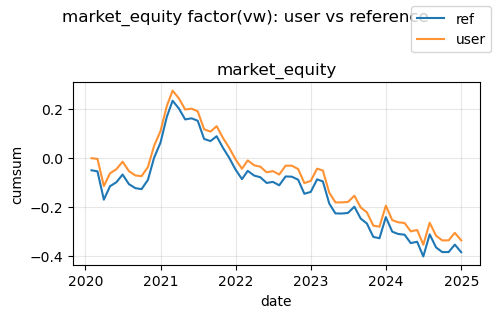

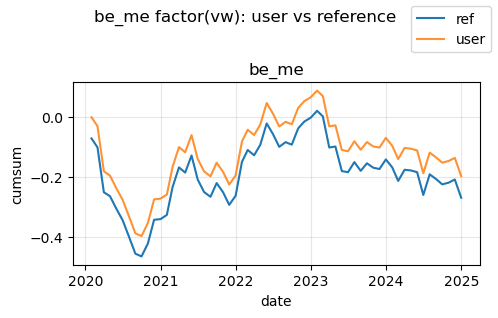

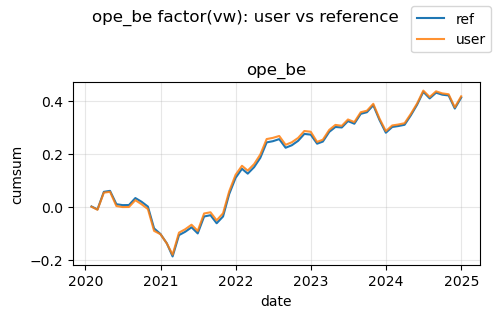

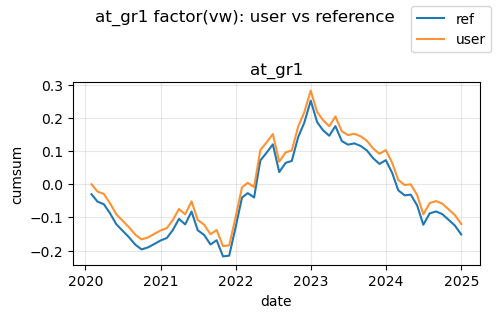

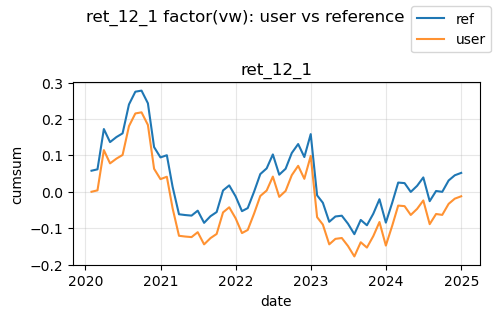

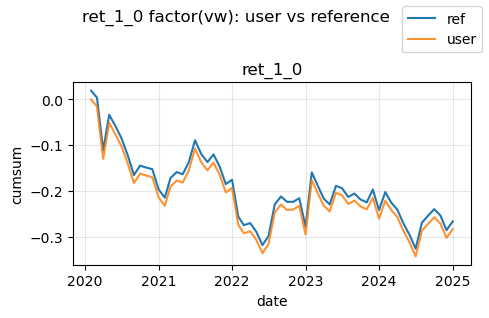

In [18]:
# Í≤∞Í≥º Ï†ÄÏû• dict
validation_reports = {}

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

for factor in factors:
    print(f"\n=== {factor.upper()} VW Factor Í≤ÄÏ¶ù ===")
    
    # 1. user factor (Series ‚Üí DataFrame)
    user_factor = pd.DataFrame(factor_returns_vw[factor])
    user_factor.columns = [factor]
    
    # 2. reference factor
    ref_factor = factor_answers_vw[factor]
    
    # üîé Í∏∏Ïù¥ Î∞è ÎÇ†Ïßú Î≤îÏúÑ Ï≤¥ÌÅ¨
    print(f"[DEBUG] user_factor: {user_factor.dropna().shape[0]}Í∞ú "
          f"({user_factor.dropna().index.min()} ~ {user_factor.dropna().index.max()})")
    print(f"[DEBUG] ref_factor : {ref_factor.dropna().shape[0]}Í∞ú "
          f"({ref_factor.dropna().index.min()} ~ {ref_factor.dropna().index.max()})")
    
    # 3. validator Ïã§Ìñâ
    report = validator.validate_factor(
        user=user_factor,
        reference=ref_factor,
        return_plot=True,
        plot_title=f"{factor} factor(vw): user vs reference",
    )
    
    # 4. Í≤∞Í≥º Ï∂úÎ†•
    print("Í¥ÄÏ∏°ÏπòÏàò:", report.n_obs, 
          "ÏãúÏûëÏùº:", report.date_start, 
          "Ï¢ÖÎ£åÏùº:", report.date_end)
    print(
        "mse:", _fmt(report.mse),
        "rmse:", _fmt(report.rmse),
        "mae:", _fmt(report.mae),
        "corr:", _fmt(report.corr),
    )
    
    # 5. dictÏóê Ï†ÄÏû•
    validation_reports[factor] = report


VW_CAP

=== MARKET_EQUITY VW_CAP Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== BE_ME VW_CAP Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== OPE_BE VW_CAP Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== AT_GR1 VW_CAP Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== RET_12_1 VW_CAP Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== RET_1_0 VW_CAP Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===
=== MARKET_EQUITY VW_CAP Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== BE_ME VW_CAP Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== OPE_BE VW_CAP Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== AT_GR1 VW_CAP Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_12_1 VW_CAP Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_1_0 VW_CAP Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== MARKET_EQUITY VW_CAP Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== BE_ME VW_CAP Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== OPE_BE VW_CAP Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== AT_GR1 VW_CAP Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_12_1 VW_CAP Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===
=== RET_1_0 VW_CAP Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===


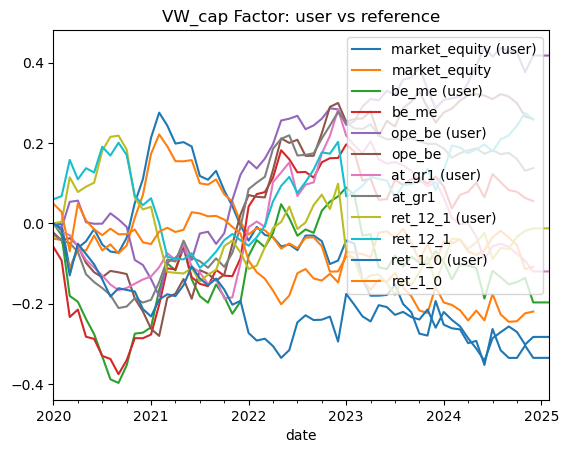

In [23]:
# Top=Short Ïù∏ Ìå©ÌÑ∞Îì§
top_as_short = ["market_equity", "at_gr1", "ret_1_0"]

# === Í≤∞Í≥º Ï†ÄÏû• dict ===
short_ports_vw = {}
long_ports_vw = {}

# === Capped VW Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ Ìï®Ïàò ===
def get_vw_cap_weights(me_df, mask_shifted, cap=0.8):
    """
    me_df        : wide_market_equity (Ï†ÑÏ≤¥ Ï¢ÖÎ™© ME, t-1 Í∏∞Ï§Ä)
    mask_shifted : t-1 ÏãúÏ†ê Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎßàÏä§ÌÅ¨
    cap          : Í∞úÎ≥Ñ weight ÏÉÅÌïú (Í∏∞Î≥∏=0.8)
    """
    # Ìè¨Ìä∏ MEÎßå Ï∂îÏ∂ú
    port_me = me_df.where(mask_shifted)
    
    # Í∏∞Î≥∏ VW weight (Ìè¨Ìä∏ ÎÇ¥Î∂Ä Ìï© = 1)
    weights = port_me.div(port_me.sum(axis=1), axis=0)
    
    # cap Ï†ÅÏö© ÌõÑ normalize
    capped = weights.clip(upper=cap)
    #capped_norm = capped.div(capped.sum(axis=1), axis=0)  # Ìï© Îã§Ïãú 1
    
    return capped


# === Í≤∞Í≥º Ï†ÄÏû• dict ===
top_weights_vw_cap = {}
middle_weights_vw_cap = {}
bottom_weights_vw_cap = {}

for factor in factors:
    print(f"=== {factor.upper()} VW_CAP Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ ===")
    
    # (1) Ìï≠ÏÉÅ market_equity Í∏∞Ï§ÄÏúºÎ°ú Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    me_df = wide_market_equity
    
    # (2) Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎßàÏä§ÌÅ¨ (t-1 Í∏∞Ï§Ä shift)
    top_mask_shifted    = top_masks[factor].shift(1)
    middle_mask_shifted = middle_masks[factor].shift(1)
    bottom_mask_shifted = bottom_masks[factor].shift(1)
    
    # (3) VW Cap Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    top_weights_vw_cap[factor]    = get_vw_cap_weights(me_df.shift(1), top_mask_shifted, cap=0.8)
    middle_weights_vw_cap[factor] = get_vw_cap_weights(me_df.shift(1), middle_mask_shifted, cap=0.8)
    bottom_weights_vw_cap[factor] = get_vw_cap_weights(me_df.shift(1), bottom_mask_shifted, cap=0.8)

# === Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ìï®Ïàò ===
def get_portfolio_return(ret_df, weights):
    return (ret_df * weights).sum(axis=1)


# === Í≤∞Í≥º Ï†ÄÏû• dict ===
top_rets_vw_cap = {}
middle_rets_vw_cap = {}
bottom_rets_vw_cap = {}

for factor in factors:
    print(f"=== {factor.upper()} VW_CAP Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===")
    
    # (1) factorÎ≥Ñ Í∞ÄÏ§ëÏπò Î∂àÎü¨Ïò§Í∏∞
    top_w    = top_weights_vw_cap[factor]
    middle_w = middle_weights_vw_cap[factor]
    bottom_w = bottom_weights_vw_cap[factor]
    
    # (2) ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ret_exc √ó weight)
    top_rets_vw_cap[factor]    = get_portfolio_return(wide_ret_exc, top_w)
    middle_rets_vw_cap[factor] = get_portfolio_return(wide_ret_exc, middle_w)
    bottom_rets_vw_cap[factor] = get_portfolio_return(wide_ret_exc, bottom_w)

    # Í≤∞Í≥º Ï†ÄÏû• dict
factor_returns_vw_cap = {}
factor_answers_vw_cap = {}

for factor in factors:
    print(f"=== {factor.upper()} VW_CAP Ìå©ÌÑ∞ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ===")
    
    # (1) Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Î∂àÎü¨Ïò§Í∏∞
    top_ret    = top_rets_vw_cap[factor]
    bottom_ret = bottom_rets_vw_cap[factor]
    
    # (2) Ìå©ÌÑ∞ Î∞©Ìñ• Í≤∞Ï†ï (Top=Short Ïó¨Î∂Ä)
    if factor in top_as_short:
        factor_ret_vw_cap = bottom_ret - top_ret   # ÎÜíÏùÄ Í∞í short
    else:
        factor_ret_vw_cap = top_ret - bottom_ret   # ÎÇÆÏùÄ Í∞í short
    
    # (3) Ï†ÄÏû•
    factor_returns_vw_cap[factor] = factor_ret_vw_cap
    
    # (4) reference factor Î∂àÎü¨Ïò§Í∏∞
    factor_answer = q.load_factors(
        country="usa",
        dataset="factor",
        weighting="vw_cap",
        factors=[factor],
    )
    factor_answers_vw_cap[factor] = factor_answer
    
    # (5) Í∑∏ÎûòÌîÑ ÎπÑÍµê
    ax = factor_ret_vw_cap.cumsum().plot(label=f"{factor} (user)")
    factor_answer.loc["2020-01-31":, :].cumsum().plot(ax=ax, label=f"{factor} (ref)")
    ax.set_title("VW_cap Factor: user vs reference")
    ax.legend()



=== MARKET_EQUITY VW_cap Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 62Í∞ú (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 1188Í∞ú (1926-01-31 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 60 ÏãúÏûëÏùº: 2020-01-31 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.016 mae: 0.012 corr: 0.939

=== BE_ME VW_cap Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 62Í∞ú (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 890Í∞ú (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 60 ÏãúÏûëÏùº: 2020-01-31 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.021 mae: 0.016 corr: 0.907

=== OPE_BE VW_cap Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 62Í∞ú (2020-01-31 00:00:00 ~ 2025-02-28 00:00:00)
[DEBUG] ref_factor : 890Í∞ú (1950-11-30 00:00:00 ~ 2024-12-31 00:00:00)
Í¥ÄÏ∏°ÏπòÏàò: 60 ÏãúÏûëÏùº: 2020-01-31 00:00:00 Ï¢ÖÎ£åÏùº: 2024-12-31 00:00:00
mse: 0.000 rmse: 0.022 mae: 0.017 corr: 0.813

=== AT_GR1 VW_cap Factor Í≤ÄÏ¶ù ===
[DEBUG] user_factor: 62Í∞ú (2020-01-31 00

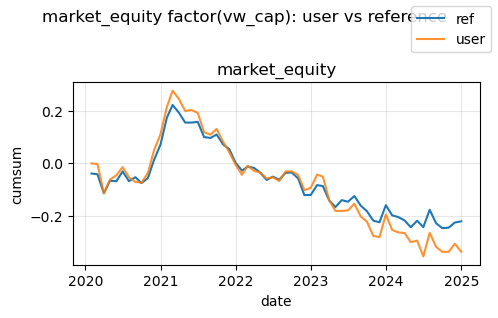

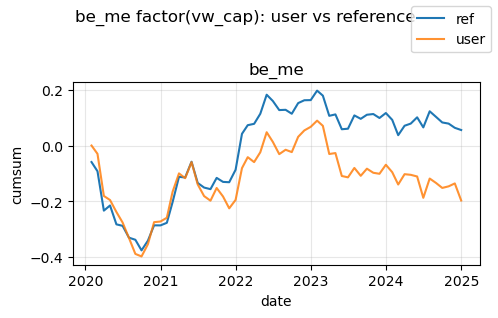

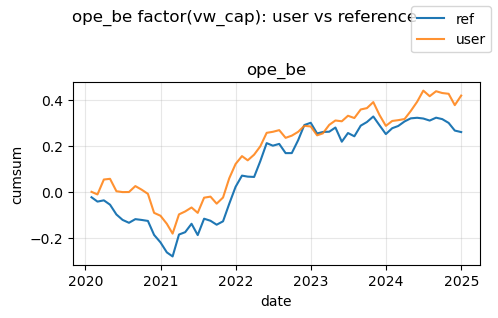

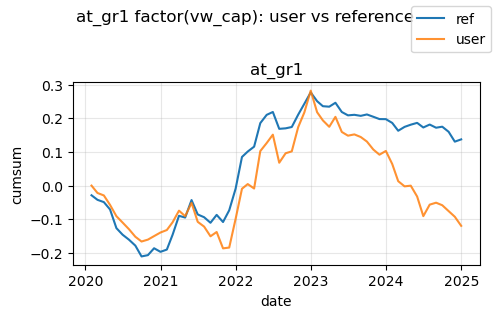

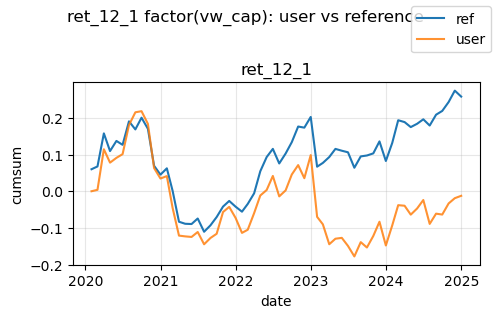

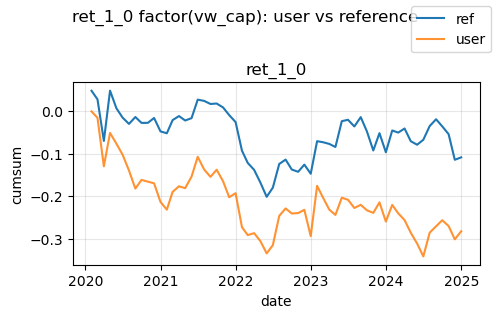

In [24]:
# Í≤∞Í≥º Ï†ÄÏû• dict
validation_reports = {}

def _fmt(x):
    return f"{x:.3f}" if x is not None else "nan"

for factor in factors:
    print(f"\n=== {factor.upper()} VW_cap Factor Í≤ÄÏ¶ù ===")
    
    # 1. user factor (Series ‚Üí DataFrame)
    user_factor = pd.DataFrame(factor_returns_vw_cap[factor])
    user_factor.columns = [factor]
    
    # 2. reference factor
    ref_factor = factor_answers_vw_cap[factor]
    
    # üîé Í∏∏Ïù¥ Î∞è ÎÇ†Ïßú Î≤îÏúÑ Ï≤¥ÌÅ¨
    print(f"[DEBUG] user_factor: {user_factor.dropna().shape[0]}Í∞ú "
          f"({user_factor.dropna().index.min()} ~ {user_factor.dropna().index.max()})")
    print(f"[DEBUG] ref_factor : {ref_factor.dropna().shape[0]}Í∞ú "
          f"({ref_factor.dropna().index.min()} ~ {ref_factor.dropna().index.max()})")
    
    # 3. validator Ïã§Ìñâ
    report = validator.validate_factor(
        user=user_factor,
        reference=ref_factor,
        return_plot=True,
        plot_title=f"{factor} factor(vw_cap): user vs reference",
    )
    
    # 4. Í≤∞Í≥º Ï∂úÎ†•
    print("Í¥ÄÏ∏°ÏπòÏàò:", report.n_obs, 
          "ÏãúÏûëÏùº:", report.date_start, 
          "Ï¢ÖÎ£åÏùº:", report.date_end)
    print(
        "mse:", _fmt(report.mse),
        "rmse:", _fmt(report.rmse),
        "mae:", _fmt(report.mae),
        "corr:", _fmt(report.corr),
    )
    
    # 5. dictÏóê Ï†ÄÏû•
    validation_reports[factor] = report
